In [24]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import tensorflow_probability as tfp 
import seaborn as sns 
import geopandas 
import datetime

In [25]:
sns.set_theme()

In [26]:
plt.rcParams["figure.figsize"] = (15, 10)

In [27]:
hpai_main = pd.read_csv('data_files/combinedDataset20221130 _1_.csv')
hpai_wild = pd.read_csv('data_files/wildBirdData20221130 _1_.csv')
hpai_poultry = pd.read_excel('data_files/GBPR Poultry Premises Extract 01Dec22 _1_.xlsx')

## Preview the data

In [28]:
hpai_main.head(5)

,dprNumber,aivNumber,reportDate,Status,NDI1Type,Resolution,Stock Details,CPH,Country,dprID,...,PZ/SZ presence,Lat,Long,Genomics,cullStart,cullEnd,dispComplete,cdEffective,County,premisesType
0,DPR 2022/389,NaN,28/11/2022,Pending,Report case- Clinical,NaN,"80,000",38/270/6002,England,2022 389,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Suffolk,Ducks
1,DPR 2022/388,NaN,28/11/2022,Pending,Report case- Clinical,NaN,3342,06/369/0014,England,2022 388,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cheshire West and Chester,Turkeys
2,DPR 2022/387,NaN,26/11/2022,Pending,Samples taken for laboratory testing,NaN,"Approx 400 chickens, 78\r\r\ngeese, 18 turkeys...",28/461/0002,England,2022 387,...,NaN,NaN,NaN,NaN,30/11/2022,30/11/2022,NaN,01/12/2022,Norfolk,Chickens
3,DPR 2022/386,AIV 2022/218,26/11/2022,Confirmed,Interim Results - POSITIVE,Confirmed on Lab,32000,70/224/0125,Scotland,2022 386,...,NaN,57.568064,-2.493343,NaN,29/11/2022,NaN,NaN,NaN,Aberdeenshire,Chickens
4,DPR 2022/385,NaN,25/11/2022,Not Confirmed,Final Report,Negated on Clinical,4,NaN,Wales,2022 385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Caerphilly,Chickens


In [29]:
hpai_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dprNumber       504 non-null    object 
 1   aivNumber       324 non-null    object 
 2   reportDate      540 non-null    object 
 3   Status          504 non-null    object 
 4   NDI1Type        504 non-null    object 
 5   Resolution      495 non-null    object 
 6   Stock Details   499 non-null    object 
 7   CPH             369 non-null    object 
 8   Country         503 non-null    object 
 9   dprID           504 non-null    object 
 10  aivID           324 non-null    object 
 11  ipNumber        134 non-null    float64
 12  region          191 non-null    object 
 13  approxNumBirds  190 non-null    object 
 14  Year            324 non-null    float64
 15  Season          324 non-null    float64
 16  Subtype         249 non-null    object 
 17  infDate         320 non-null    obj

Comments: 
- unique ID for each farm
- dates (resolution is daily) 
    - format is DD/MM/YYYY
    - reported date for initial infection? 
    - culling dates for end of infectious period (can be longer than 1 day - should factor into the model, decay term? ) 
    - clarify: infDate, confDate, reportDate
- herd details (types of birds present - cat var in model to tell difference in susceptibility) 
- herd size
- spatial component (have geolocation and regional area - can impute from geolocation if need be)

In [30]:
hpai_poultry.head()

,Location Id,AHO,Created Datetime,Updated Datetime,Easting,Northing,OS Map Reference
0,L1000007,APHA Leicester,2008-07-15,2013-08-22 09:58:00,458300.0,263000.0,SP5830063000
1,L1000018,APHA Worcester,2008-07-18,2019-01-24 01:16:00,427801.0,282900.0,SP2780182900
2,L1000019,APHA Leicester,2008-07-18,2019-01-02 02:40:00,487900.0,269200.0,SP8790069200
3,L1000036,APHA Worcester,2008-07-24,2011-05-20 03:23:00,423200.0,292900.0,SP2320092900
4,L1000080,APHA Worcester,2008-08-06,2019-01-25 04:12:00,407851.0,301448.0,SK0785101448


In [31]:
hpai_poultry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58119 entries, 0 to 58118
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Location Id       58119 non-null  object        
 1   AHO               57743 non-null  object        
 2   Created Datetime  58119 non-null  datetime64[ns]
 3   Updated Datetime  58119 non-null  datetime64[ns]
 4   Easting           58118 non-null  float64       
 5   Northing          58118 non-null  float64       
 6   OS Map Reference  58118 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 3.1+ MB


Comments: 

- spatial data for farms 
- long/lat coordinates for mapping

In [32]:
hpai_wild.head()

,Bird ID,Lab ID,Species Name,Final Result,Virus Isolated,Date Received,COUNTY,COUNTRY,speciesName,birdFamily,...,Date PHE informed,High Path,Postcode,Comment,date,easting,northing,latitude,longitude,osGridRef
0,AVA-21-050799,AV001973-21,TUFTED_DUCK,Negative,NaN,2021-10-05T00:00:00Z,GREATER LONDON,ENGLAND,TUFTED_DUCK,ducks/geese/swans,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AVA-21-050998,AV001979-21,BLACK-HEADED_GULL,Negative,NaN,2021-10-06T00:00:00Z,TYNE & WEAR,ENGLAND,BLACK-HEADED_GULL,gulls/terns,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AVA-21-051051,AV001985-21,UNSPECIFIED_BIRD,Negative,NaN,2021-10-07T00:00:00Z,ABERDEENSHIRE,SCOTLAND,UNSPECIFIED_BIRD,unspecified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AVA-21-051052,AV001985-21,UNSPECIFIED_BIRD,Negative,NaN,2021-10-07T00:00:00Z,ABERDEENSHIRE,SCOTLAND,UNSPECIFIED_BIRD,unspecified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AVA-21-051053,AV001985-21,UNSPECIFIED_BIRD,Negative,NaN,2021-10-07T00:00:00Z,ABERDEENSHIRE,SCOTLAND,UNSPECIFIED_BIRD,unspecified,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
hpai_wild.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7356 entries, 0 to 7355
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Bird ID                5273 non-null   object 
 1   Lab ID                 7247 non-null   object 
 2   Species Name           5273 non-null   object 
 3   Final Result           5273 non-null   object 
 4   Virus Isolated         4650 non-null   object 
 5   Date Received          5273 non-null   object 
 6   COUNTY                 4306 non-null   object 
 7   COUNTRY                4306 non-null   object 
 8   speciesName            7356 non-null   object 
 9   birdFamily             7341 non-null   object 
 10  Order                  7341 non-null   object 
 11  originalReportedOSRef  4941 non-null   object 
 12  originalOSEasting      4718 non-null   float64
 13  originalOSNorthing     4719 non-null   float64
 14  Case Ref Number        2934 non-null   object 
 15  Inde

In [34]:
hpai_wild[['Date Received']].dropna()

,Date Received
0,2021-10-05T00:00:00Z
1,2021-10-06T00:00:00Z
2,2021-10-07T00:00:00Z
3,2021-10-07T00:00:00Z
4,2021-10-07T00:00:00Z
...,...
5268,2022-11-28T00:00:00Z
5269,2022-11-28T00:00:00Z
5270,2022-11-28T00:00:00Z
5271,2022-11-25T00:00:00Z


Comments: 

- dead wild bird reports w/ accompanying HPAI test result 
- long/lat location of carcass 
- species of wild bird (are some species more likely to be the cause?)

# EDA and Data Cleaning

## Time filtering

In [35]:
# Time variables for hpai_main:
# reportDate
# infDate
# confDate
# cullStart
# cullEnd

hpai_main_dates = hpai_main[['reportDate', 'infDate',
                                                                                      'confDate', 'cullStart', 'cullEnd']].apply(lambda x: pd.to_datetime(x, format='%d/%m/%Y'), axis=1)
hpai_main_dates[['reportDate', 'infDate', 'confDate', 'cullStart', 'cullEnd']].tail()

,reportDate,infDate,confDate,cullStart,cullEnd
535,2021-01-26,2021-01-18,2021-01-27,NaT,NaT
536,2021-02-05,2021-01-30,2021-02-06,NaT,NaT
537,2021-02-10,2020-02-03,2021-02-11,NaT,NaT
538,2021-03-26,2021-03-18,2021-03-27,NaT,NaT
539,2021-03-30,2021-03-21,2021-04-01,NaT,NaT


In [36]:
hpai_main_dates[['reportDate', 'infDate', 'confDate', 'cullStart', 'cullEnd']] = hpai_main_dates[['reportDate', 'infDate', 'confDate', 'cullStart', 'cullEnd']].apply(lambda x: pd.to_datetime(x, format='%d/%m/%Y'))

<Axes: xlabel='reportDate', ylabel='Count'>

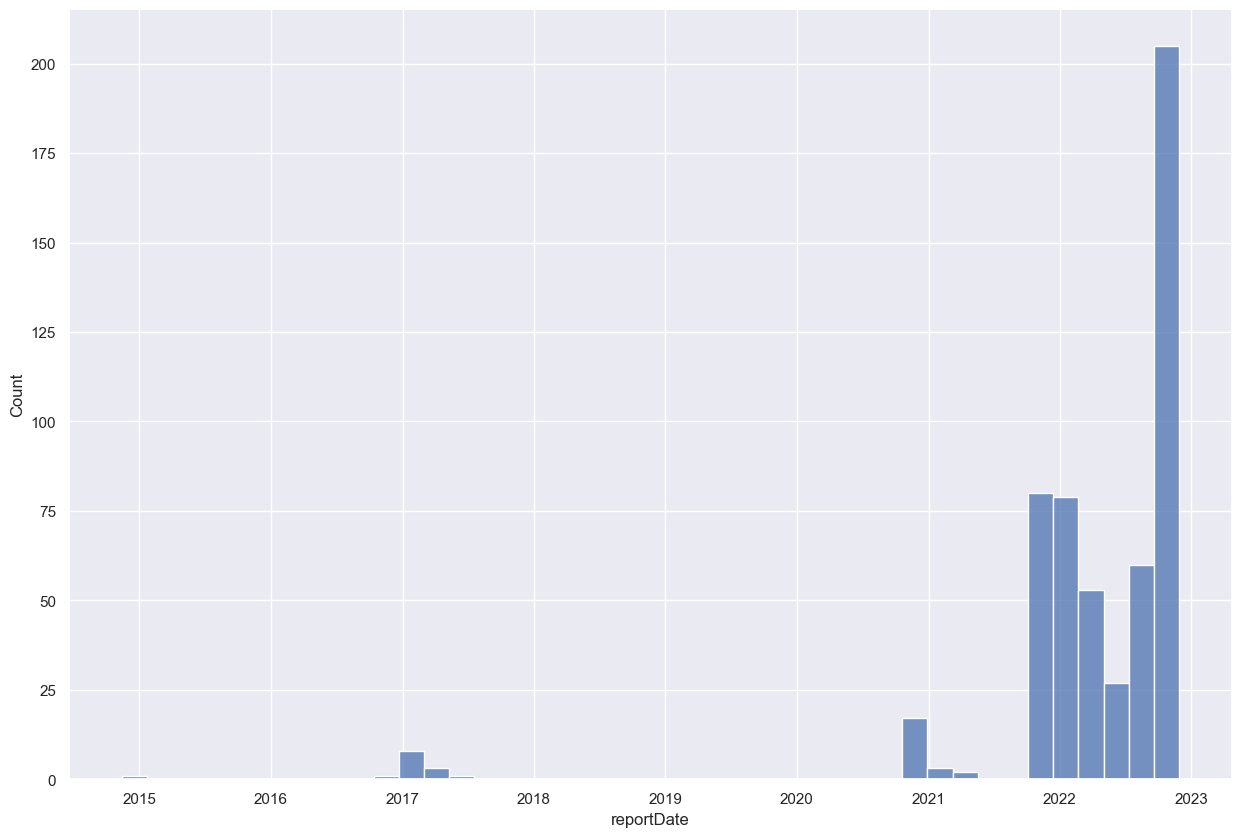

In [37]:
sns.histplot(data = hpai_main_dates, x = 'reportDate')

In [38]:
# most cases are in 2020 onwards so we filter out the 2017 wave 
hpai_main_dates = hpai_main_dates[hpai_main_dates.reportDate >= datetime.datetime(2020,1, 1, 0,0,0)]

In [39]:
# Time variables for hpai_wild:
# Date Received
# Test date
# Date PHE informed

hpai_wild[['Date Received', 'Test date', 'Date PHE informed']] = hpai_wild[['Date Received', 'Test date', 'Date PHE informed']].apply(
    lambda x: pd.to_datetime(x, infer_datetime_format=True), axis=1)

/var/folders/_q/07k1y14x087brt3tmd2bs1740000gn/T/ipykernel_19919/2861473677.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  lambda x: pd.to_datetime(x, infer_datetime_format=True), axis=1)
/var/folders/_q/07k1y14x087brt3tmd2bs1740000gn/T/ipykernel_19919/2861473677.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  lambda x: pd.to_datetime(x, infer_datetime_format=True), axis=1)
/var/folders/_q/07k1y14x087brt3tmd2bs1740000gn/T/ipykernel_19919/2861473677.py:7: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a futur

## Geopandas attempts

In [40]:
sns.scatterplot(data=hpai_main_dates, x = 'Long', y = 'Lat', style = 'region', hue='premisesType')

ValueError: Could not interpret value `Long` for parameter `x`

<AxesSubplot:xlabel='easting', ylabel='northing'>

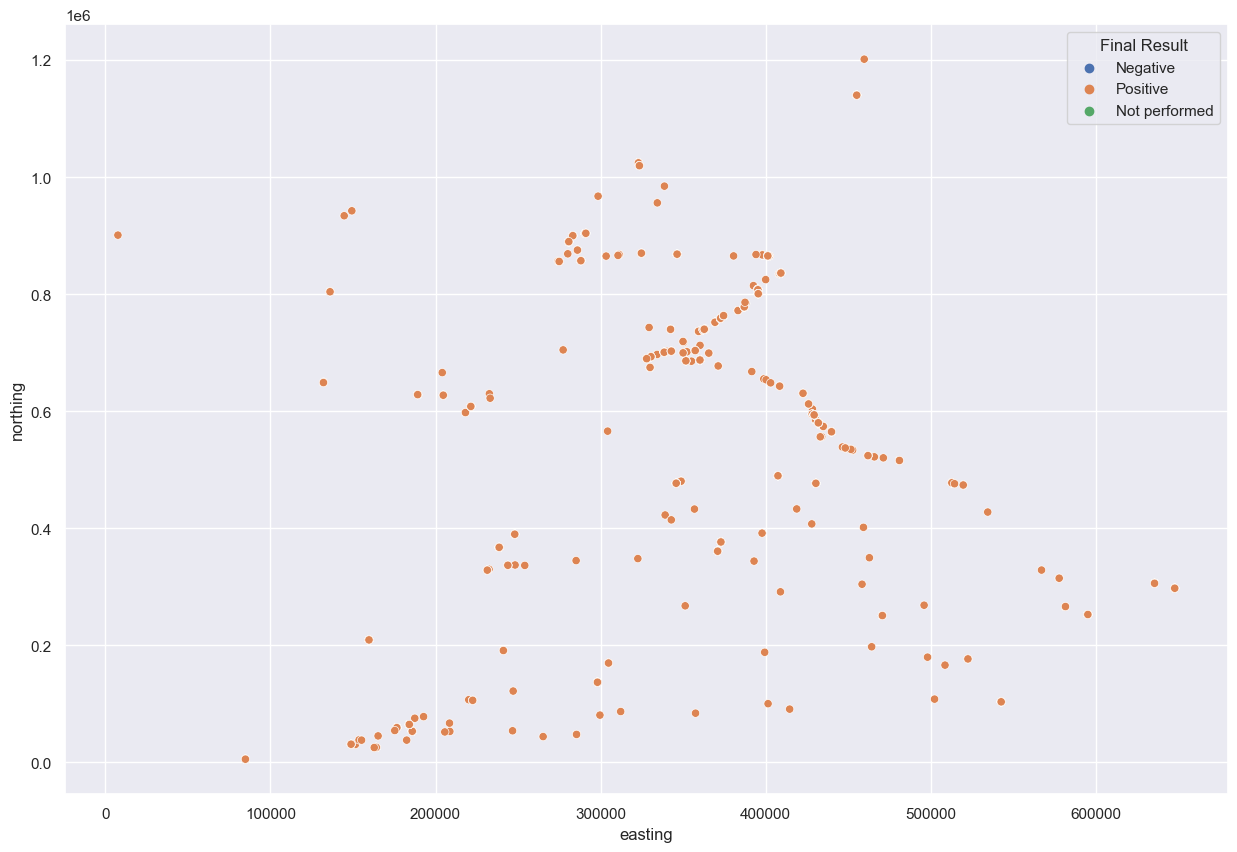

In [ ]:
sns.scatterplot(data=hpai_wild, x = 'easting', y = 'northing', hue='Final Result')

In [ ]:
geo_hpai_main = geopandas.GeoDataFrame(
    hpai_main, geometry=geopandas.points_from_xy(hpai_main.Long, hpai_main.Lat))

In [ ]:
geo_hpai_wild = geopandas.GeoDataFrame(
    hpai_wild, geometry=geopandas.points_from_xy(hpai_wild.longitude, hpai_wild.latitude))

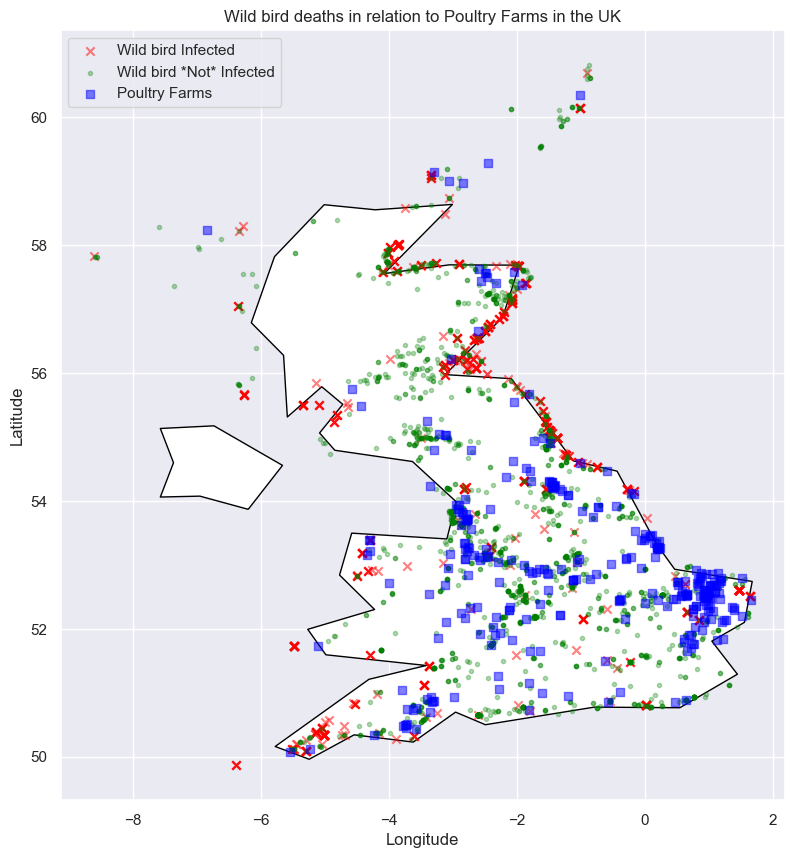

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


# restrict to UK.
ax = world[world.name == 'United Kingdom'].plot(
    color='white', edgecolor='black')

# plot our ``GeoDataFrame``.
geo_hpai_wild[geo_hpai_wild['Final Result'] == 'Positive'].plot(
    ax=ax, color='red', alpha=0.5, label='Wild bird Infected',  marker='x')
geo_hpai_wild[geo_hpai_wild['Final Result'] != 'Positive'].plot(
    ax=ax, color='green', alpha=0.3, label='Wild bird *Not* Infected',  marker='.')
geo_hpai_main.plot(ax=ax, color='blue', marker='s',
                   label='Poultry Farms', alpha=0.5)

plt.title('Wild bird deaths in relation to Poultry Farms in the UK')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc="upper left")
plt.show()

# Extracting modeling data 

Proposed model: SEINR 

In [ ]:
# spatial data - farm level
hpai_poultry[['Location Id', 'Easting', 'Northing']].to_csv('data_files/farm_locations.csv')

In [ ]:
# time data - case level (will not have every farm infected)
hpai_main_dates.to_csv('data_files/hpai_temporal_data.csv')

In [43]:
# farm characteristics - from the hpai_main dataset so they align with the hpai_main_dates
# characteristics available for every infected/case but not for every farm (i.e. occults)! Harder to simulate
hpai_main[['approxNumBirds', 'Season', 'speciesPresent', 'businessType', 'premisesType']]

# any derivative data sets from the main file can be matched by index, o/w need to match by location? 

,approxNumBirds,Season,speciesPresent,businessType,premisesType
0,80000,NaN,NaN,NaN,Ducks
1,3342,NaN,NaN,NaN,Turkeys
2,400,NaN,NaN,NaN,Chickens
3,32000,2022.0,Chickens,Commercial,Chickens
4,4,NaN,NaN,NaN,Chickens
...,...,...,...,...,...
535,NaN,2020.0,Game Birds,Commercial,Game Birds
536,NaN,2020.0,Chickens,Commercial,Chickens
537,NaN,2020.0,Game Birds,Commercial,Game Birds
538,NaN,2020.0,Chickens,Commercial,Chickens


In [42]:
hpai_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dprNumber       504 non-null    object 
 1   aivNumber       324 non-null    object 
 2   reportDate      540 non-null    object 
 3   Status          504 non-null    object 
 4   NDI1Type        504 non-null    object 
 5   Resolution      495 non-null    object 
 6   Stock Details   499 non-null    object 
 7   CPH             369 non-null    object 
 8   Country         503 non-null    object 
 9   dprID           504 non-null    object 
 10  aivID           324 non-null    object 
 11  ipNumber        134 non-null    float64
 12  region          191 non-null    object 
 13  approxNumBirds  190 non-null    object 
 14  Year            324 non-null    float64
 15  Season          324 non-null    float64
 16  Subtype         249 non-null    object 
 17  infDate         320 non-null    obj